# CD Legislative Changes - WIP

**This notebook is a work in  progress and no conclusion should be taken as final - they are formative thoughts**

During the last decade, controlled drugs legislation has been amended on various occasions due to concerns. In this notebook we will set out to examine the impact of reclassification on Prescribing Patterns

- [Gabapentinoids](#gaba)
- [Tramadol](#tramadol)
- [Zopiclone & Zaleplon](#zdrugs) 
- [Lisdexamfetamine](#lisdex) 
- [Overall Summary](#summ) 



In [1]:
#import libraries required for analysis
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from ebmdatalab import bq, charts, maps
import os

# Gabapentinoids <a id='gaba'></a>
In April 2019 Gabapentinoids (i.e. pregabaln and gabapentin) were reclassified under the misuse of drugs act. This followed the [Advisory Committee of Misuse of Drugs recommending reclassification due to their concerns](https://www.gov.uk/government/news/pregabalin-and-gabapentin-to-be-controlled-as-class-c-drugs) over rising prescribing, misuse and deaths associated with both medicines. The reclassification we intended to bring in stronger controls and reduce the chances of medicines being used inapprorpiately.

On OpenPrescribing we have various measures on gabapentinoid prescribing including including a measure of total use by using [Daily Defined Doses (DDD) to include both medicines in a single measure](https://openprescribing.net/measure/gabapentinoidsddd/).


In [2]:
sql1 = '''
SELECT
  month,
  pct_id,
  sum(numerator) as total_gaba,
FROM
  `ebmdatalab.measures.ccg_data_gabapentinoidsddd` AS p
GROUP BY
month,
pct_id
'''

df_gaba = bq.cached_read(sql1, csv_path=os.path.join('..', 'data', 'df_gaba.csv'))
df_gaba['month'] = pd.to_datetime(df_gaba['month'])
df_gaba.rename(columns={'pct_id':'pct'}, inplace=True) ##prep for maps library whe  pct must be colum name
df_gaba.head(5)




,month,pct,total_gaba
0,2020-04-01,07P,59784.327778
1,2020-03-01,07P,63836.238889
2,2019-11-01,07P,60419.316667
3,2019-07-01,07P,64346.488889
4,2018-03-01,07P,60850.283333


(0, 30000000)

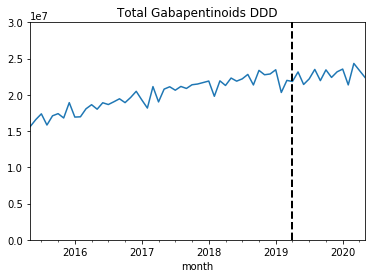

In [3]:
ax = df_gaba.groupby(["month"])['total_gaba'].sum().plot(kind='line', title="Total Gabapentinoids DDD")
ax.axvline(pd.to_datetime('2019-04-01'), color='black', linestyle='--', lw=2) ##law change
plt.ylim(0, 30000000 )

*Discussion* : Overall the changes to CD regulations fo not appear to have substantially changed prescribing of gabapentinoids. A visual inspection of the graph shows a possible levelling off of the total quanity prescribed.

*TODO / Further Investigations*: ?

# Tramadol <a id='tramadol'></a>

In June 2014 tramdol was reclassified as a schedule 3 CD and the [ONS reported 5% drop in tramadol prescribing](https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/bulletins/deathsrelatedtodrugpoisoninginenglandandwales/2015registrations) as well as the first fall in deaths related to tramadol since the first recorded death. The [Royal Pharmaceutical Society have a brefing here](https://www.rpharms.com/about-us/news/details/Rescheduling-of-gabapentin-and-pregabalin-to-Schedule-3-Controlled-Drugs-from-1-April-2019) (login required). OpenPrescribing item data goes back to 2011 but raw prescribing information only goes back to January 2014. We will do a two step analysis
1. Assess overall change in items and cost (indicative of qty) 

2. a) Work our total amounts of mg of tramadol dispensed in raw data for six months prior to the change. <br />
    b) Work out tablet quantities for the 50mg and 100mg

In [4]:
sql2 = '''
SELECT
  month,
  bnf_name,
  bnf_code,
  SUM(items) AS total_items,
  SUM(actual_cost) AS total_cost
FROM
  ebmdatalab.hscic.normalised_prescribing AS rx
WHERE
 bnf_code LIKE '040702040%'
GROUP BY
  month,
  bnf_name,
  bnf_code
ORDER BY
  month
'''

df_tramadol = bq.cached_read(sql2, csv_path=os.path.join('..', 'data', 'df_tramadol.csv'))
df_tramadol['month'] = pd.to_datetime(df_tramadol['month'])
df_tramadol.head(5)

,month,bnf_name,bnf_code,total_items,total_cost
0,2010-08-01 00:00:00+00:00,Tramacet_Tab 37.5mg/325mg,040702040BFAAAU,6741,93751.57
1,2010-08-01 00:00:00+00:00,Tramulief SR_Tab 150mg,040702040BKABAD,11,141.20
2,2010-08-01 00:00:00+00:00,Tramadol HCl_Orodisper Tab 50mg,040702040AAATAT,775,7404.95
3,2010-08-01 00:00:00+00:00,Tramadol/Paracet_Tab Eff 37.5/325mg S/F,040702040AABABA,171,1881.57
4,2010-08-01 00:00:00+00:00,Dromadol SR_Tab 100mg,040702040BEABAC,20,251.99


(0, 800000)

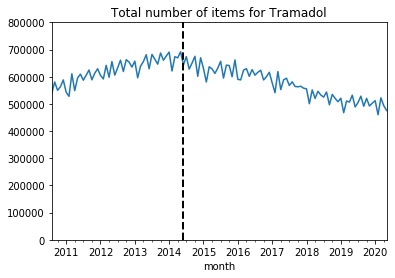

In [5]:
ax = df_tramadol.groupby(["month"])['total_items'].sum().plot(kind='line', title="Total number of items for Tramadol")
ax.axvline(pd.to_datetime('2014-06-01'), color='black', linestyle='--', lw=2) ##law change
plt.ylim(0, 800000)

(0, 4597263.389132996)

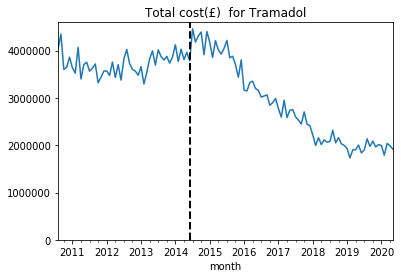

In [6]:
ax = df_tramadol.groupby(["month"])['total_cost'].sum().plot(kind='line', title="Total cost(£)  for Tramadol")
ax.axvline(pd.to_datetime('2014-06-01'), color='black', linestyle='--', lw=2) ##law change
plt.ylim(0, )

In [7]:
#for prototype I'll just take a look at 50mg caps
sql3 = '''
SELECT
  month,
  bnf_name,
  bnf_code,
SUM(CASE
      WHEN SUBSTR(bnf_code,14,2)='AA' THEN quantity * 50 #Tramadol 50mg capsules
      WHEN SUBSTR(bnf_code,14,2)='AT' THEN quantity * 50 #Tramadol 50mg orodispersible tablets sugar free
      WHEN SUBSTR(bnf_code,14,2)='AG' THEN quantity * 50 #Tramadol 50mg modified-release capsules
      WHEN SUBSTR(bnf_code,14,2)='AY' THEN quantity * 50 #Tramadol 50mg modified-release tablets
      WHEN SUBSTR(bnf_code,14,2)='AF' THEN quantity * 50 #Tramadol 50mg soluble tablets sugar free
      ELSE 0 END) AS tramadol_mg
FROM
  ebmdatalab.hscic.normalised_prescribing
WHERE
 bnf_code LIKE '040702040%'
GROUP BY
  month,
  bnf_name,
  bnf_code
ORDER BY
  month
'''

df_raw_tramadol = bq.cached_read(sql3, csv_path=os.path.join('..', 'data', 'df_tramadol_raw.csv'))
df_raw_tramadol['month'] = pd.to_datetime(df_raw_tramadol['month'])
df_raw_tramadol.head(5)

,month,bnf_name,bnf_code,tramadol_mg
0,2010-08-01 00:00:00+00:00,Tradorec XL_Tab 200mg,040702040BIABAE,0.0
1,2010-08-01 00:00:00+00:00,Mabron_Tab 200mg M/R (Morningside),040702040BHACAE,0.0
2,2010-08-01 00:00:00+00:00,Marol_Tab 100mg M/R,040702040BNAAAC,0.0
3,2010-08-01 00:00:00+00:00,Tramacet_Tab Eff 37.5mg/325mg,040702040BFABBA,0.0
4,2010-08-01 00:00:00+00:00,Maxitram SR_Cap 100mg,040702040BPABAH,0.0


(0, 3500000000)

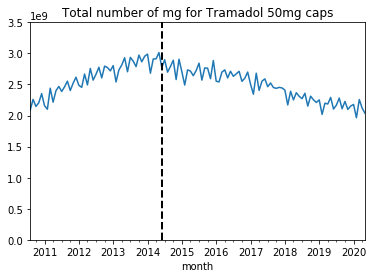

In [8]:
ax = df_raw_tramadol.groupby(["month"])['tramadol_mg'].sum().plot(kind='line', title="Total number of mg for Tramadol 50mg caps")
ax.axvline(pd.to_datetime('2014-06-01'), color='black', linestyle='--', lw=2) ##law change
plt.ylim(0, 3500000000 )

*Discussion*: There has been some reductions in tramadol changes indicating some success in the changes to regulations.

*TODO / Further Investigations*: Finalise the Total number of mg graph across all products. 

# Z-Drugs <a id='zdrugs'></a>

Here the change is about reducing the amount on prescription at any one time. WE should look at decreases as well as a measure of 28/30 day scripts.

•	https://www.rpharms.com/about-us/news/details/Controlled-drug-changes--tramadol--lisdexamfetamine--zopiclone-and-zaleplon



In [9]:
sql4 = '''
WITH
bnf_tab AS (
SELECT
DISTINCT chemical,
chemical_code
FROM
ebmdatalab.hscic.bnf )
SELECT
  month,
  chemical,
  SUM(items) AS total_items,
  SUM(actual_cost) AS total_cost
FROM
  ebmdatalab.hscic.normalised_prescribing AS rx
LEFT JOIN
bnf_tab
ON
chemical_code =SUBSTR(rx.bnf_code,1,9)
WHERE
 bnf_code LIKE '0401010W0%' OR #zaleplon
 bnf_code LIKE '0401010Z0%'    #zopiclone
GROUP BY
  month,
  chemical
ORDER BY
  month
'''

df_z_drugs = bq.cached_read(sql4, csv_path=os.path.join('..', 'data', 'df_z_drugs.csv'))
df_z_drugs['month'] = pd.to_datetime(df_z_drugs['month'])
df_z_drugs.head(5)

,month,chemical,total_items,total_cost
0,2010-08-01 00:00:00+00:00,Zopiclone,421868,647624.49
1,2010-08-01 00:00:00+00:00,Zaleplon,248,1090.55
2,2010-09-01 00:00:00+00:00,Zopiclone,451915,689550.55
3,2010-09-01 00:00:00+00:00,Zaleplon,228,1004.73
4,2010-10-01 00:00:00+00:00,Zopiclone,430882,552587.48


In [10]:
df_zopi = df_z_drugs.loc[df_z_drugs["chemical"] == "Zopiclone"]

In [11]:
df_zap = df_z_drugs.loc[df_z_drugs["chemical"] == "Zaleplon"]

(0, 371.65)

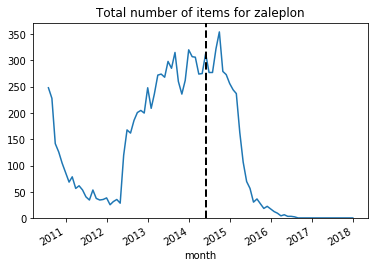

In [12]:
ax = df_zap.groupby(["month"])['total_items'].sum().plot(kind='line', title="Total number of items for zaleplon")
ax.axvline(pd.to_datetime('2014-06-01'), color='black', linestyle='--', lw=2) ##law change
plt.ylim(0, )

(0, 600000)

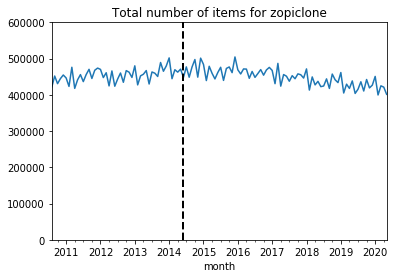

In [13]:
ax = df_zopi.groupby(["month"])['total_items'].sum().plot(kind='line', title="Total number of items for zopiclone")
ax.axvline(pd.to_datetime('2014-06-01'), color='black', linestyle='--', lw=2) ##law change
plt.ylim(0, 600000 )

It is recommended that a maximum quantity supplied should not exceed 30 days,for Schedule 2, 3 and 4 controlled drugs. Unlike tramadol & Gabapentinoids, zopiclone is prescribed once daily and there exists a single tablet. Therefore we can reasonably use the quantity on prescription  as a reasonable surrogate for the length of prescription e.g. 28 = 28 days. 


In [14]:
### here we extract data for modelling we will use 31 days for one month.
sql5 = '''
SELECT
  CAST(month AS DATE) AS month,
  pct,
  SUM(CASE
      WHEN quantity_per_item>31 THEN items
      ELSE 0
  END) AS items_breach,
  SUM(CASE
      WHEN quantity_per_item>31 THEN total_quantity
      ELSE 0
  END) AS qty_breach,
  SUM(total_quantity) AS all_QI,
  IEEE_DIVIDE(SUM(CASE
      WHEN quantity_per_item>31 THEN total_quantity
      ELSE 0
  END),
      SUM(total_quantity)) AS percent_qty_breach
FROM
 ebmdatalab.hscic.raw_prescribing_normalised AS presc
JOIN
  hscic.ccgs AS ccgs
ON
presc.pct=ccgs.code
WHERE
bnf_code LIKE "0401010Z0%"   ##zopiclone
AND
bnf_name LIKE '%_tab%'  ##this restricts to tablets 
AND
ccgs.org_type='CCG'
GROUP BY
  month,
  pct
ORDER BY
  percent_qty_breach DESC
    '''

df_zop_breach = bq.cached_read(sql5, csv_path='zop_breach.csv')
df_zop_breach['month'] = df_zop_breach['month'].astype('datetime64[ns]')
df_zop_breach.head()

,month,pct,items_breach,qty_breach,all_QI,percent_qty_breach
0,2014-06-01,01C,1,56.0,70.0,0.800000
1,2014-04-01,01C,1,56.0,80.0,0.700000
2,2014-05-01,01C,1,56.0,133.0,0.421053
3,2014-05-01,10C,140,8324.0,20306.0,0.409928
4,2014-07-01,10C,143,8454.0,21548.0,0.392333


(0, 40612.65)

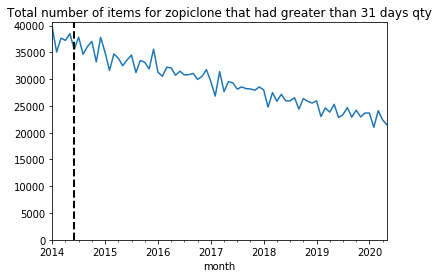

In [15]:
ax = df_zop_breach.groupby(["month"])['items_breach'].sum().plot(kind='line', title="Total number of items for zopiclone that had greater than 31 days qty")
ax.axvline(pd.to_datetime('2014-06-01'), color='black', linestyle='--', lw=2) ##law change
plt.ylim(0,)

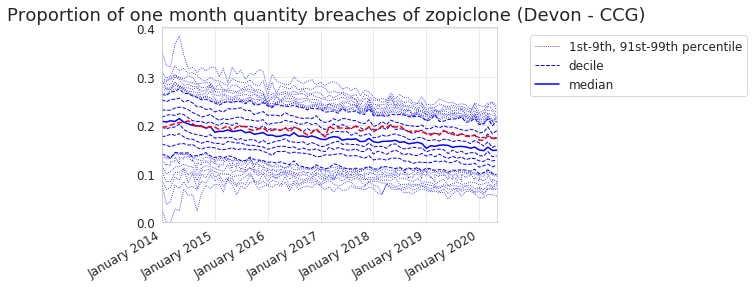

In [16]:
#create sample deciles

charts.deciles_chart(
        df_zop_breach,
        period_column='month',
        column='percent_qty_breach',
        title="Proportion of one month quantity breaches of zopiclone (Devon - CCG) ",
        show_outer_percentiles=True)

#add in example CCG (Devon - 15N)
df_subject = df_zop_breach.loc[df_zop_breach['pct'] == '15N'].sort_values(by=['month'])
plt.plot(df_subject['month'], df_subject['percent_qty_breach'], 'r--')

plt.show()

In [17]:
##Restrict to latest month (may-2019) to create a map
may_df_zop = df_zop_breach.loc[(df_zop_breach['month'] == '2020-05-01')]

In [18]:
#create choropeth map 
plt.figure(figsize=(12, 7))
plt = maps.ccg_map(may_df_zop, title="Proportion of one month quanity breaches of zopiclone", column='percent_qty_breach', separate_london=True)
plt.show()

BaseException: Data contains CCG codes we don't know about: ['16C' '18C' '26A' '27D' '36J' '36L' '42D' '52R' '70F' '71E' '72Q' '78H'
 '84H' '91Q' '92A' '92G' '93C' '97R']

<Figure size 864x504 with 0 Axes>

*Discussion*: Firstly changes to zaleplon schedules seem to have ensured the prescribing never took off but this could also be due to other reasons. The total number of zopicolne items remains largely unchanged since the changes but the amount of prescriptions for longer periods has decreased. However we do observe substantial variation in the rate of breaches of guidance to only prescribe a single months zopiclone at a time.

*TODO / Further Investigations* 1. Calculate the DDD/total mg for zopiclone 2. Get charts fixed. 

# Lisdexamfetamine <a id='lisdex'></a>

Lisdexamfetamine will became a Schedule 2 controlled drug (CD POM) on June 10th 2014. Lisdexamfetamine has only been prescribed/dispensed in England since 2010, as an American import, with a licensed product [_Elvanse_](https://openprescribing.net/dmd/?q=elvanse&obj_types=vtm&obj_types=vmp&obj_types=amp&obj_types=vmpp&obj_types=ampp&include=unavailable&submit=Search) becoming available cicra 2013. The aim of reclassification of lisdexamfetamine was to apply the same controls that its prodrug dexamfetamine was already restricted under as opposed to recognised issues with this new medicine.

In [19]:
sql6 = '''
SELECT
  month,
  bnf_name,
  bnf_code,
  SUM(items) AS total_items,
  SUM(actual_cost) AS total_cost
FROM
  ebmdatalab.hscic.normalised_prescribing AS rx
WHERE
 bnf_code LIKE '0404000U0%'
GROUP BY
  month,
  bnf_name,
  bnf_code
ORDER BY
  month
'''

df_lisdex = bq.cached_read(sql6, csv_path=os.path.join('..', 'data', 'df_lisdex.csv'))
df_lisdex['month'] = pd.to_datetime(df_lisdex['month'])
df_lisdex.head(5)

,month,bnf_name,bnf_code,total_items,total_cost
0,2012-07-01 00:00:00+00:00,Vyvanse_Cap 70mg,0404000U0BBAFAF,1,192.74
1,2012-10-01 00:00:00+00:00,Vyvanse_Cap 40mg,0404000U0BBACAC,1,114.73
2,2012-11-01 00:00:00+00:00,Vyvanse_Cap 40mg,0404000U0BBACAC,1,1172.46
3,2012-11-01 00:00:00+00:00,Vyvanse_Cap 70mg,0404000U0BBAFAF,1,203.06
4,2012-12-01 00:00:00+00:00,Vyvanse_Cap 70mg,0404000U0BBAFAF,1,200.20


(0, 18487.3)

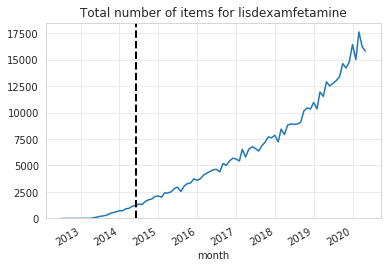

In [20]:
ax = df_lisdex.groupby(["month"])['total_items'].sum().plot(kind='line', title="Total number of items for lisdexamfetamine")
ax.axvline(pd.to_datetime('2014-06-01'), color='black', linestyle='--', lw=2) ##law change
plt.ylim(0, )

*Discussion* Changes to CD regs for this new medicine are not possible to assess due to the very low rate pf prescribing prior to the changes. Uptake will be of interest to some folk.

*TODO / Further investigation* nil

# Overall Summary <a id='summ'></a>

- *Discussion* : Overall the changes to CD regulations do not appear to substantially affect prescribing patterns however it may result in some slowing of growth rates.
- *TODO / Further Investigations*: 
    - Add deaths from poisoning from these substances
    - Add TODOS for each section
    - Further investigation and documentation of specific changes
    - Consult with controlled drugs experts
    - Share summary for further investigation